Problem
============
Given the time series of CPU consumption (cpu time) of a process, can we predict eta for a similar process in future? And can we answer questions like 1) is the process running slower (consuming less CPU) than how it is supposed to be? 2) Given the CPU consumption rate of a running process and from the past history, can we tell how long this instance is going to take?

In [1]:
import pandas as pd
import os
os.listdir('.')

['digest.csv',
 'digest.2.csv',
 'digest.9.csv',
 'wrap1.py',
 'tmp',
 'output.txt',
 'digest.7.csv',
 'fib.py',
 '1.output.txt',
 'digest.py',
 'Analysis.ipynb',
 'digest.3.csv',
 'digest.1.csv',
 'digest.5.csv',
 'wrap.sh',
 'digest.6.csv',
 'Test.ipynb',
 '.ipynb_checkpoints',
 'digest.8.csv',
 'digest.10.csv',
 'digest.4.csv']

digest.NO.csv files above are the time series of 10 different runs of a same process with same shape. The processes were setup to be CPU intensive and to sleep for a random period after each run to give a step function with ramps. This should help in validating the regression model that we arrive at below.

In [2]:
csv1 = pd.read_csv('./digest.1.csv')
csv1.head()

,timestamp,cputime
0,0.00,1.04
1,1.03,2.06
2,2.07,2.78
3,3.11,2.78
4,4.15,2.78


Loading all the input files and merging them into a single big data set and then plotting them in a scatter.

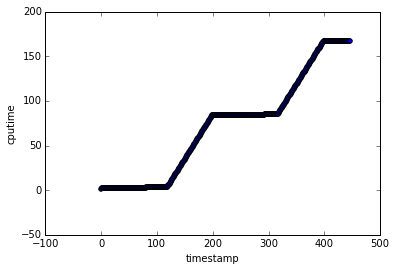

In [3]:
%matplotlib inline
csv = None
for i in range(10):
    csv_ = pd.read_csv('./digest.%d.csv' % (i+1))
    if csv is None:
        csv = csv_
    else:
        csv.append(csv_)
csv.plot(kind='scatter', x = 'timestamp', y='cputime')


Clearly, the shape above is not simple one and doesn't seem to fit into standard linear or polynomial models. After trying ploynomial (linear with features mapped to higher degrees, upto 4 in this case) regression and support vector regression using 'poly' kernel, 'rbf' kernel seems to work perfectly well.

TODO: Train with 'training' data set and test against 'cross validation' data set. 

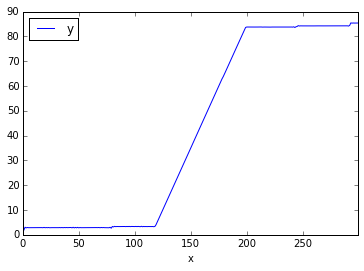

In [4]:
from sklearn.svm import SVR
lr = SVR(kernel='rbf', C=1e3, degree=2)
x = lr.fit(csv[['timestamp']][:400], csv['cputime'][:400])
x
df = pd.DataFrame([(p,x.predict(p)[0]) for p in range(300)], columns=['x', 'y'])
df.plot(x='x', y='y')

In [23]:
# at runtime
r = 100

# max runtime - job completes here
m = 420

# tweak this manually for tests
c = x.predict(r)[0]

# expected output at 'r'
C = x.predict(r)[0]

# lagging factor
lf = c/C

# current average rate of change
avr_curr = c/r

# remaining work till r (should be > 0 when c < C)
rw = (C-c)/avr_curr

# pending work from r till completion
ideal_avr_from_r = (x.predict(m)[0] - C) / (m-r)

# real avr_from_r - the average rate of change from r is less than ideal due to lagging factor
real_avr_from_r = lf * ideal_avr_from_r

# runtime remaining from r till completion
runtime = (x.predict(m)[0] - C)/real_avr_from_r

runtime+rw

# Output summary:
# c = 1:1294.7743589634861
# c = 1.5: 829.84957264232412
# c = 2: 597.38717948174303
# c = 2.5: 457.90974358539449
# c = 3: 364.92478632116206
# ideal condition(not low CPU): 320.0 (i.e. )

320.0